In [1]:
from ginkgo.data import get_stockinfos
from tqdm import tqdm
from ginkgo.data import get_bars
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 预处理

## 数据获取

In [2]:
infos = get_stockinfos()
infos = infos[:200]
codes = infos['code'].values
print(codes)

没有缓存，重新计算并缓存


🗿 Got 5375 records about StockInfo from mysql.

🐫 FUNCTION get_stockinfos excuted in 0.35445 seconds.

['300355.SZ' '600332.SH' '300611.SZ' '001306.SZ' '300752.SZ' '688581.SH'
 '002648.SZ' '600415.SH' '002470.SZ' '301026.SZ' '001366.SZ' '002789.SZ'
 '603589.SH' '688210.SH' '603006.SH' '300088.SZ' '000166.SZ' '000428.SZ'
 '600356.SH' '600760.SH' '603368.SH' '300535.SZ' '001332.SZ' '301198.SZ'
 '300081.SZ' '600166.SH' '300305.SZ' '688023.SH' '300970.SZ' '300225.SZ'
 '002864.SZ' '301332.SZ' '000973.SZ' '603998.SH' '601800.SH' '600183.SH'
 '601727.SH' '600622.SH' '605158.SH' '300212.SZ' '600685.SH' '000933.SZ'
 '300610.SZ' '603768.SH' '300818.SZ' '688292.SH' '002517.SZ' '600116.SH'
 '000975.SZ' '000829.SZ' '001287.SZ' '603358.SH' '000338.SZ' '300867.SZ'
 '300999.SZ' '601319.SH' '601789.SH' '002697.SZ' '688251.SH' '600691.SH'
 '300459.SZ' '600227.SH' '601022.SH' '601921.SH' '600863.SH' '831175.BJ'
 '000663.SZ' '300251.SZ' '603600.SH' '600720.SH' '688692.SH' '300654.SZ'
 '688766.SH' '600549.SH' '002184.SZ' '002139.SZ' '300909.SZ' '601288.SH'
 '600390.SH' '603206.SH' '873570.BJ' '600993.SH' '0

In [3]:
date_start = "2000-01-01"
date_end = "2023-01-01"

## 清洗 标准化

In [4]:
result_df = pd.DataFrame()
for index, stock_info in tqdm(infos.iterrows(), total=infos.shape[0], desc="Processing stocks"):
    code = stock_info['code']
    bar_df = get_bars(code=code, start_date=date_start, end_date=date_end, as_dataframe=True)

    if bar_df.empty:
        continue
    
    # 计算因子
    bar_df['return_5d'] = (bar_df['close'].shift(-5) - bar_df['close']) / bar_df['close']
    bar_df['volatility'] = (bar_df['high'] - bar_df['low']) / bar_df['close'].shift(1)
    bar_df['volume_change'] = bar_df['volume'].pct_change()


    
    bar_df.drop(columns=['frequency','uuid','meta','desc','source','code','timestamp'], inplace=True)
    # 删除因子生成后的 NaN 行
    bar_df = bar_df.replace([np.inf, -np.inf], np.nan).dropna()
    # 在标准化前再次检查
    if bar_df.shape[0] == 0:
        continue
    inf_check = bar_df.isin([np.inf, -np.inf]) | bar_df.isna()
    if inf_check.any().any():
        print("Found inf or NaN before scaling.")
        display(bar_df[inf_check.any(axis=1)])  # 显示包含 inf 或 NaN 的行
        break


    # 标准化因子




    # 假设因子列已经在result_df中
    factor_columns = bar_df.columns  # 修改为实际因子列名
    scaler = StandardScaler()

    # 对因子列进行标准化
    try:
        bar_df[factor_columns] = scaler.fit_transform(bar_df[factor_columns])
    except Exception as e:
        print(e)
        inf_check = bar_df.isin([np.inf, -np.inf])
        inf_rows_columns = inf_check[inf_check.any(axis=1)]  # 只显示包含inf的行
        display(inf_rows_columns)
        break
    result_df = pd.concat([result_df, bar_df], ignore_index=True)
display(result_df)

Processing stocks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  8.00it/s]


,open,high,low,close,volume,amount,return_5d,volatility,volume_change
0,1.119361,1.292268,1.117929,1.353574,-0.440415,0.431966,1.006038,3.188567,-0.591612
1,1.515155,1.542612,1.489602,1.445711,-0.274727,1.035885,-0.322176,1.162874,0.235973
2,1.520349,1.631443,1.544822,1.592717,-0.453757,0.575248,-0.881687,1.607262,-0.412480
3,1.536970,1.532517,1.553318,1.557519,-0.634560,0.050465,0.079243,-0.071014,-0.518776
4,1.543203,1.611254,1.489602,1.441570,-0.573064,0.225188,1.068347,1.938371,0.089706
...,...,...,...,...,...,...,...,...,...
443659,-1.627163,-1.613944,-1.698757,-1.704914,0.195254,-0.046781,-0.506896,0.933723,0.018296
443660,-1.733184,-1.718161,-1.763102,-1.789354,-0.093134,-0.238480,0.343243,0.308160,-0.527368
443661,-1.796796,-1.739005,-1.763102,-1.789354,-0.223412,-0.321486,0.465875,-0.001955,-0.385346
443662,-1.775592,-1.759848,-1.827448,-1.831574,-0.247781,-0.338138,0.221457,0.663219,-0.192405


In [5]:
display(result_df.info())
display(result_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443664 entries, 0 to 443663
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   open           443664 non-null  float64
 1   high           443664 non-null  float64
 2   low            443664 non-null  float64
 3   close          443664 non-null  float64
 4   volume         443664 non-null  float64
 5   amount         443664 non-null  float64
 6   return_5d      443664 non-null  float64
 7   volatility     443664 non-null  float64
 8   volume_change  443664 non-null  float64
dtypes: float64(9)
memory usage: 30.5 MB


None

,open,high,low,close,volume,amount,return_5d,volatility,volume_change
count,4.436640e+05,4.436640e+05,4.436640e+05,4.436640e+05,4.436640e+05,4.436640e+05,4.436640e+05,4.436640e+05,4.436640e+05
mean,1.870591e-17,2.447143e-17,-2.498392e-17,9.737323e-18,-8.071729e-18,1.947465e-17,-4.244064e-19,-1.366108e-17,1.165116e-18
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.197053e+00,-3.114318e+00,-3.093820e+00,-3.302311e+00,-1.464434e+00,-1.408525e+00,-1.092971e+01,-1.952104e+00,-1.683919e+00
25%,-7.137258e-01,-7.124839e-01,-7.144628e-01,-7.133047e-01,-5.509279e-01,-5.047626e-01,-4.851472e-01,-6.819352e-01,-3.022589e-01
50%,-2.714012e-01,-2.730024e-01,-2.707377e-01,-2.718709e-01,-3.154234e-01,-3.210943e-01,-2.294099e-02,-2.649058e-01,-1.017777e-01
75%,4.859528e-01,4.837445e-01,4.897627e-01,4.859107e-01,1.804179e-01,9.218553e-02,4.541224e-01,3.894444e-01,6.998721e-02
max,9.880243e+00,9.647454e+00,9.634494e+00,9.871046e+00,2.359571e+01,2.331315e+01,2.068680e+01,3.660243e+01,6.896273e+01


## 再次确认数据

In [6]:
result_df.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
amount           0
return_5d        0
volatility       0
volume_change    0
dtype: int64

# 因子分析

检验各个因子与5日收益率的相关性

open            -0.058892
high            -0.059129
low             -0.059401
close           -0.059995
volume          -0.035181
amount          -0.054122
return_5d        1.000000
volatility       0.002917
volume_change   -0.005496
Name: return_5d, dtype: float64


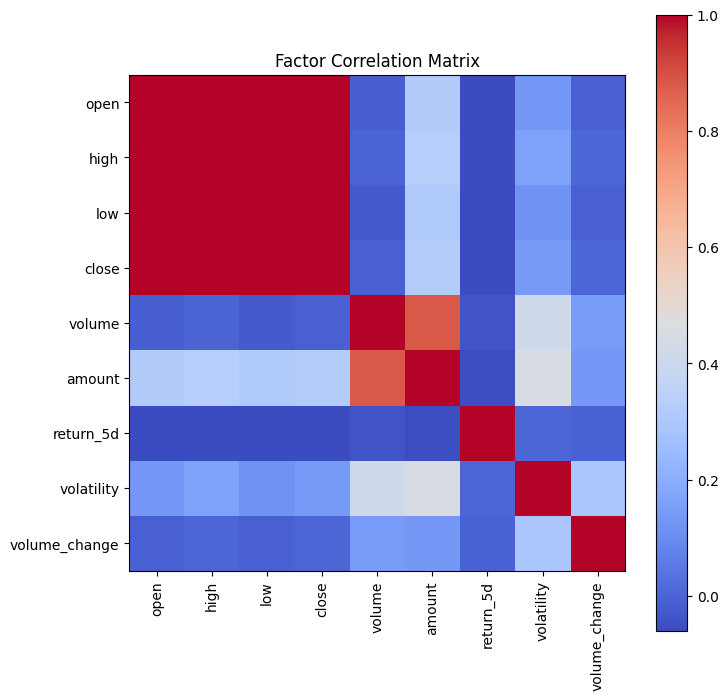

In [25]:
# 计算因子之间的相关性
correlation_matrix = result_df.corr(method='spearman')

correlation_with_target = correlation_matrix['return_5d']
print(correlation_with_target)

# 使用matplotlib绘制相关性矩阵
plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

# 设置标签
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)

# 添加标题
plt.title("Factor Correlation Matrix")
plt.show()

这些因子与5日收益相关性较低, 并没有显著的预测能力.

# 线性回归

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
raw_data = result_df
display(raw_data)
x = raw_data.drop(columns=['return_5d'])
y = raw_data['return_5d']

,open,high,low,close,volume,amount,return_5d,volatility,volume_change
0,1.119361,1.292268,1.117929,1.353574,-0.440415,0.431966,1.006038,3.188567,-0.591612
1,1.515155,1.542612,1.489602,1.445711,-0.274727,1.035885,-0.322176,1.162874,0.235973
2,1.520349,1.631443,1.544822,1.592717,-0.453757,0.575248,-0.881687,1.607262,-0.412480
3,1.536970,1.532517,1.553318,1.557519,-0.634560,0.050465,0.079243,-0.071014,-0.518776
4,1.543203,1.611254,1.489602,1.441570,-0.573064,0.225188,1.068347,1.938371,0.089706
...,...,...,...,...,...,...,...,...,...
443659,-1.627163,-1.613944,-1.698757,-1.704914,0.195254,-0.046781,-0.506896,0.933723,0.018296
443660,-1.733184,-1.718161,-1.763102,-1.789354,-0.093134,-0.238480,0.343243,0.308160,-0.527368
443661,-1.796796,-1.739005,-1.763102,-1.789354,-0.223412,-0.321486,0.465875,-0.001955,-0.385346
443662,-1.775592,-1.759848,-1.827448,-1.831574,-0.247781,-0.338138,0.221457,0.663219,-0.192405


## 标准化

原来的数据已经标准化过了,这里略过

In [9]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=42)

In [10]:
display(x_train)
display(y_train)

,open,high,low,close,volume,amount,volatility,volume_change
88297,-0.260221,-0.257921,-0.231583,-0.259486,-0.027778,-0.059881,-0.596644,0.675346
115666,-0.049439,-0.050252,-0.020322,-0.017612,1.107882,0.720470,-0.438893,0.125704
137870,-0.583124,-0.575707,-0.564897,-0.557646,-0.183782,-0.316975,-0.350280,0.125231
274215,1.898952,1.841705,1.819541,1.898530,-0.559664,-0.311158,0.100111,4.928863
106953,1.882385,1.836736,1.767348,1.729605,0.923422,0.951604,0.976328,-0.039109
...,...,...,...,...,...,...,...,...
259178,0.976805,0.993648,1.045786,1.054992,-0.716035,-0.542547,-0.449047,-0.215598
365838,-0.839124,-0.839914,-0.840878,-0.840101,-0.259502,-0.491273,-0.376737,0.130845
131932,0.769155,0.692878,0.816618,0.712005,-0.431323,-0.326285,-0.657494,-0.620560
146867,0.292897,0.305623,0.275011,0.247340,-0.433591,-0.299508,0.912571,0.258710


88297     0.418877
115666   -0.119218
137870   -0.135650
274215   -0.246042
106953   -0.163859
            ...   
259178   -0.447343
365838   -0.778199
131932    0.430750
146867   -0.439784
121958    0.867025
Name: return_5d, Length: 354931, dtype: float64

In [11]:
from sklearn.linear_model import LinearRegression

# 初始化线性回归模型
model = LinearRegression()

# 训练模型
model.fit(x_train, y_train)

LinearRegression()

## 模型评估

绘制散点图与拟合线

Mean Squared Error: 0.9933910040055409
R-squared: 0.008962003827918563


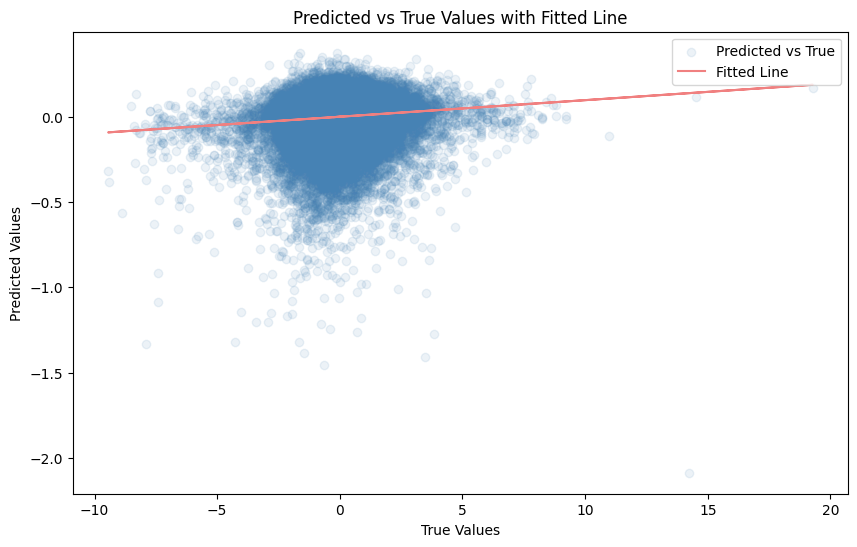

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# 使用测试集数据进行预测
y_pred = model.predict(x_test)

# 计算均方误差 (MSE)
mse = mean_squared_error(y_test, y_pred)

# 计算 R-squared（决定系数）
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


import matplotlib.pyplot as plt
import numpy as np

# 假设 y_true 是真实值，y_pred 是预测值
# 生成一个拟合线
plt.figure(figsize=(10, 6))

# 绘制散点图
plt.scatter(y_test, y_pred, color='steelblue', alpha=0.1, label="Predicted vs True")

# 绘制回归线：y = mx + b
# 使用线性回归的参数，或者使用最小二乘法拟合一条线
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color='lightcoral', label="Fitted Line")

# 添加标签
plt.title("Predicted vs True Values with Fitted Line")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()

# 显示图形
plt.show()

残差图（Residual Plot）

In [19]:
print(y_test.info()

SyntaxError: incomplete input (3506462805.py, line 1)

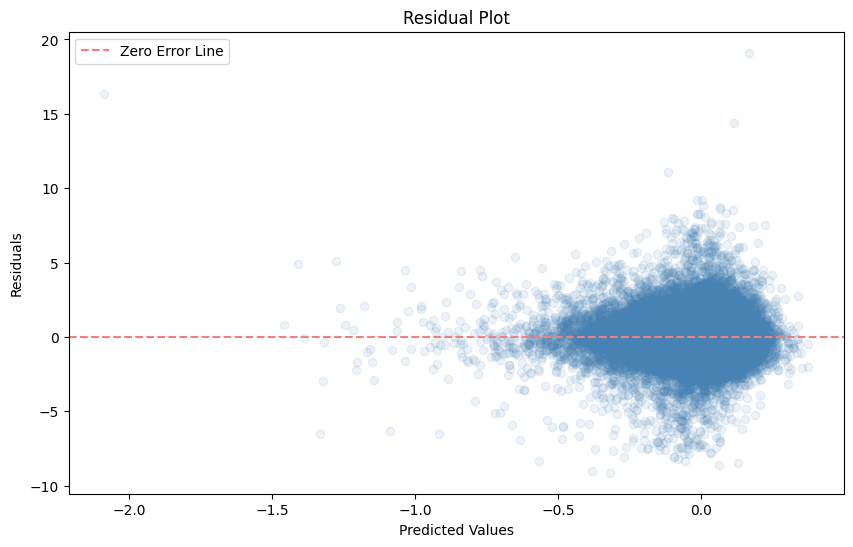

In [13]:
# 计算残差
residuals = y_test - y_pred

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='steelblue', alpha=0.1)
plt.axhline(0, color='lightcoral', linestyle='--', label="Zero Error Line")

# 添加标签
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()

# 显示图形
plt.show()

实际数据与预测值的对比图

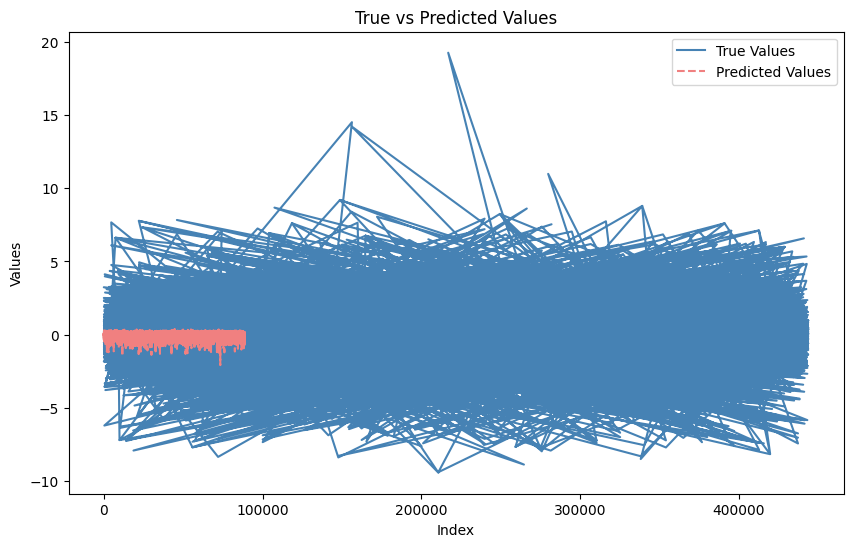

In [14]:
plt.figure(figsize=(10, 6))

# 绘制真实值与预测值的对比图
plt.plot(y_test, label='True Values', color='steelblue')
plt.plot(y_pred, label='Predicted Values', color='lightcoral', linestyle='dashed')

# 添加标签
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()

# 显示图形
plt.show()


所有证据表明,这个线性回归的模型是一拖

# 非线性模型

## 随机森林

In [15]:
# 创建随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42,verbose=1)

# 训练模型
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  7.5min


RandomForestRegressor(random_state=42, verbose=1)

In [16]:
# 使用模型进行预测
y_pred = model.predict(x_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s


Mean Squared Error: 0.9868490700008833
R-squared: 0.015488442200043973


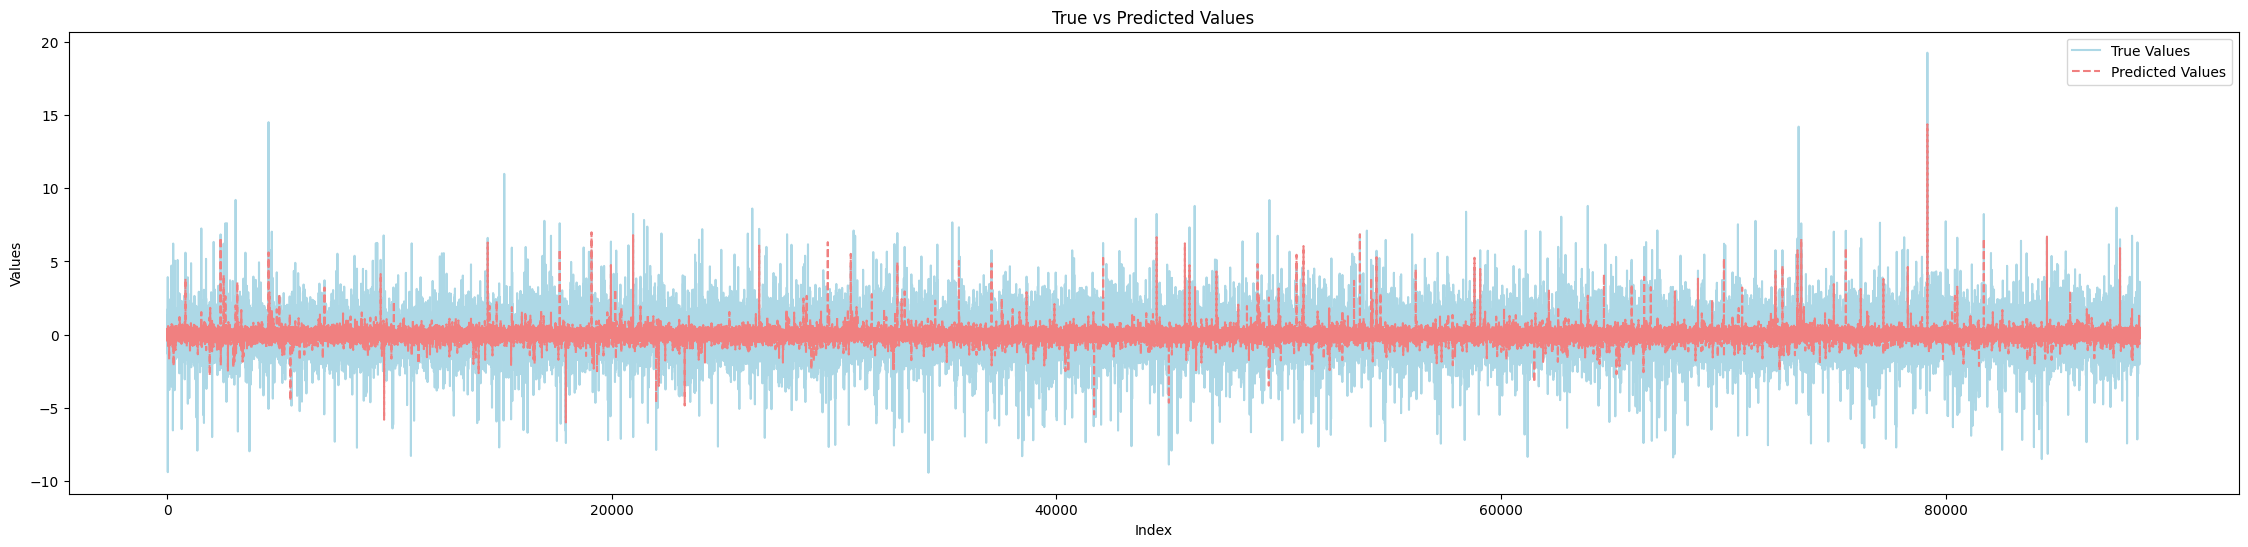

In [21]:
# 绘制真实值与预测值的对比图
plt.figure(figsize=(28, 6))
plt.plot(y_test.values, label='True Values', color='lightblue')
plt.plot(y_pred, label='Predicted Values', color='lightcoral', linestyle='dashed')

# 添加标签
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()

# 显示图形
plt.show()

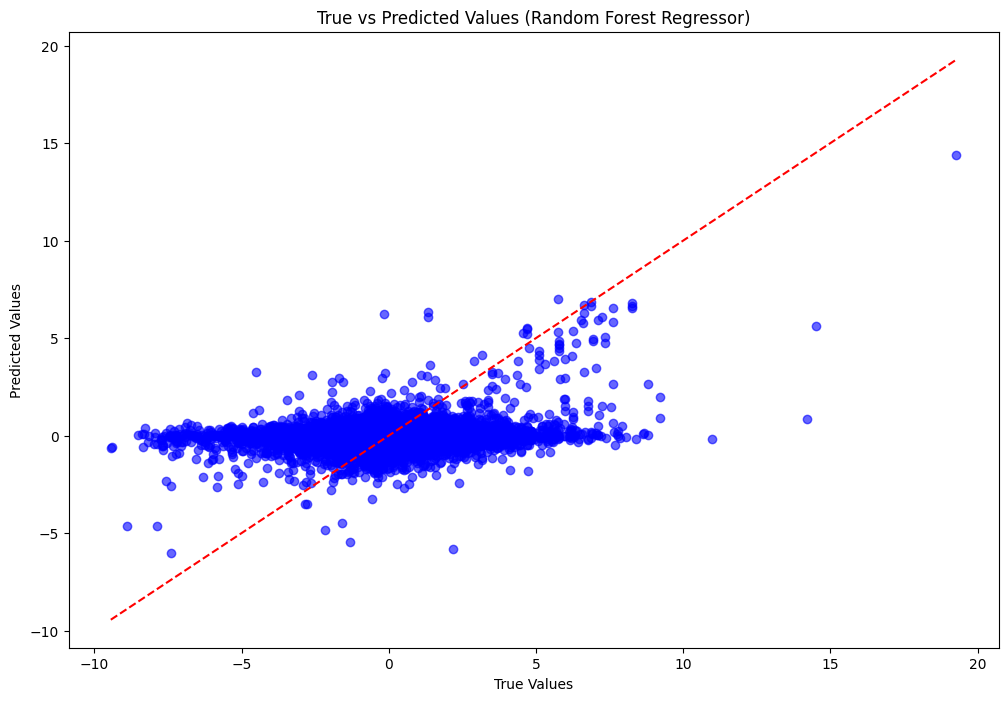

In [24]:
import matplotlib.pyplot as plt

# 创建散点图：真实值 vs 预测值
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)

# 添加对角线：表示完美预测
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# 添加标题和标签
plt.title("True vs Predicted Values (Random Forest Regressor)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

# 显示图形
plt.show()
